In [138]:
#!git clone https://github.com/anupamhap/mb.git
!git clone https://github.com/svchaudhari1995/melbournewater.git

Cloning into 'melbournewater'...
remote: Counting objects: 242, done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 242 (delta 12), reused 0 (delta 0), pack-reused 184
Receiving objects: 100% (242/242), 22.75 MiB | 22.21 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [167]:
!pwd

/content/melbournewater/melbournewater


In [0]:
import os
os.chdir("melbournewater")


In [168]:
!ls

data		  heatmap added.ipynb  kerasmodel.json
Debris Detection  kerasmodel.h5        README.md


In [0]:
import csv
import matplotlib.image as mpimg
import cv2
import numpy as np
import os
import logging
import glob

In [0]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout, Activation, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from sklearn.model_selection import train_test_split
import sklearn

In [0]:
width = 58
height = 58

images = []

In [145]:
roots   = glob.glob('data/debris/*.PNG')
non_roots   = glob.glob('data/non-debris/*.PNG')
# non_roots   += glob.glob('data/non_tree/*.jpg')
print(len(roots), len(non_roots))
img=cv2.imread(roots[0])
print(img.shape)

46 88
(127, 257, 3)


In [0]:
img_size=64
def show3img(img, img1, img2):
   plt.figure(figsize=(6, 2))
   plt.subplot(1, 3, 1)
   plt.imshow(img)
   plt.title("Raw image")
   plt.subplot(1, 3, 2)
   plt.imshow(img1)
   plt.title("Processed image")
   plt.subplot(1, 3, 3)
   plt.imshow(img2)
   plt.title("Augmented image")
   plt.show()
   
def eq_Hist(img):
   #Histogram Equalization
   img2=img.copy()
   img2[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
   img2[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
   img2[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
   return img2

def scale_img(img):
   img2=img.copy()
   sc_y=0.4*np.random.rand()+1.0
   img2=cv2.resize(img, None, fx=1, fy=sc_y, interpolation = cv2.INTER_CUBIC)
   c_x,c_y, sh = int(img2.shape[0]/2), int(img2.shape[1]/2), int(img_size/2)
   return img2

def crop(img, mar=0):
   c_x,c_y, sh = int(img.shape[0]/2), int(img.shape[1]/2), int(img_size/2-mar)
   return img[(c_x-sh):(c_x+sh),(c_y-sh):(c_y+sh)]

def rotate_img(img):
   c_x,c_y = int(img.shape[0]/2), int(img.shape[1]/2)
   ang = 30.0*np.random.rand()-15
   Mat = cv2.getRotationMatrix2D((c_x, c_y), ang, 1.0)
   return cv2.warpAffine(img, Mat, img.shape[:2])

def sharpen_img(img):
   gb = cv2.GaussianBlur(img, (5,5), 20.0)
   return cv2.addWeighted(img, 2, gb, -1, 0)
#Compute linear image transformation ing*s+m
def lin_img(img,s=1.0,m=0.0):
   img2=cv2.multiply(img, np.array([s]))
   return cv2.add(img2, np.array([m]))

#Change image contrast; s>1 - increase
def contr_img(img, s=1.0):
   m=127.0*(1.0-s)
   return lin_img(img, s, m)

def transform_img(img):
   img2=sharpen_img(img)
   img2=crop(img2,3)
   img2=contr_img(img2, 1.5)
   return eq_Hist(img2)

def augment_img(img):
   img=contr_img(img, 1.8*np.random.rand()+0.2)
   img=rotate_img(img)
   img=scale_img(img)
   return transform_img(img)


In [147]:
X_train_aug_roots = []
y_train_aug = []

def create_data(n=10):
   for i in range(len(roots)):
       img=cv2.imread(roots[i])
       img=cv2.resize(img, (64, 64))
       X_train_aug_roots.append(transform_img(img))
       y_train_aug.append(1)
       #Generate n new images out of each input image
       for j in range(n):
           X_train_aug_roots.append(augment_img(img))
           y_train_aug.append(1)      
   print("Total number of images in the augmented dataset = ", len(X_train_aug_roots))

create_data(7)

Total number of images in the augmented dataset =  368


In [148]:
def create_data(n=10):
   for i in range(len(non_roots)):
       img=cv2.imread(non_roots[i])
       img=cv2.resize(img, (64, 64))
       X_train_aug_roots.append(transform_img(img))
       y_train_aug.append(0)
       #Generate n new images out of each input image
       for j in range(n):
           X_train_aug_roots.append(augment_img(img))
           y_train_aug.append(0)      
   print("Total number of images in the augmented dataset = ", len(X_train_aug_roots))

create_data(7)

Total number of images in the augmented dataset =  1072


In [149]:
print(len(roots))
print(X_train_aug_roots[0].shape)

46
(58, 58, 3)


In [150]:
for i in range(len(roots)):
     img=cv2.imread(roots[i])
     img=cv2.resize(img, (58, 58))
     X_train_aug_roots.append(img)
     y_train_aug.append(1)

for i in range(len(non_roots)):
     img=cv2.imread(non_roots[i])
     img=cv2.resize(img, (58, 58))
     X_train_aug_roots.append(img)
     y_train_aug.append(0)
   
print(len(y_train_aug))

1206


In [0]:
activation = 'relu'
dropout = 1

def model(dshape):
    
    seq_model = Sequential()

    seq_model.add(BatchNormalization(input_shape=(dshape[0], dshape[1], dshape[2])))
    seq_model.add(Conv2D(24, (5, 5), padding='valid',
                  activation=activation, strides=(2, 2)))
    seq_model.add(Conv2D(36, (5, 5), padding='valid', activation=activation, strides=(2, 2)))
    seq_model.add(Dropout(0.6))
    seq_model.add(Conv2D(48, (5, 5), padding='valid', activation=activation, strides=(2, 2)))
    seq_model.add(Dropout(0.6))
    seq_model.add(Conv2D(64, (3, 3), padding='valid', activation=activation))
    seq_model.add(Dropout(0.6))
#   seq_model.add(Conv2D(64, (3, 3), padding='valid', activation=activation))
    seq_model.add(Flatten())
    seq_model.add(Dropout(0.6))
    seq_model.add(Dense(100, activation=activation))
    seq_model.add(Dropout(0.5))
    seq_model.add(Dense(50, activation=activation))
    seq_model.add(Dropout(0.3))
    seq_model.add(Dense(10, activation=activation))
    seq_model.add(Dense(1, activation='sigmoid'))
    seq_model.compile(loss='binary_crossentropy', optimizer=adam(), metrics=['accuracy'])
    seq_model.summary()

    return seq_model

In [0]:
from sklearn.utils import shuffle
from keras.utils.data_utils import Sequence

images, labels = shuffle(X_train_aug_roots, y_train_aug)

In [0]:
for i in range(len(X_train_aug_roots)):
  if(X_train_aug_roots[i].shape[2]!=3):
    print(X_train_aug_roots[i].shape)

In [154]:
images = np.asarray(images)
labels = np.asarray(labels)
print(images.dtype, images.shape)
print(type(images))
print(labels)

uint8 (1206, 58, 58, 3)
<class 'numpy.ndarray'>
[0 0 1 ... 0 1 0]


In [155]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import adam
#from keras.utils.data_utils import Sequence

keras_model = model((height, width, 3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 58, 58, 3)         12        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 27, 27, 24)        1824      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 36)        21636     
_________________________________________________________________
dropout_15 (Dropout)         (None, 12, 12, 36)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 4, 4, 48)          43248     
_________________________________________________________________
dropout_16 (Dropout)         (None, 4, 4, 48)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 2, 2, 64)          27712     
__________

In [169]:
keras_model.fit(images, labels, epochs=100, batch_size=32, verbose=1, shuffle=True, validation_split=0.2)

Train on 964 samples, validate on 242 samples
Epoch 1/100
964/964 [==============================] - 3s 3ms/step - loss: 0.2876 - acc: 0.8817 - val_loss: 0.3749 - val_acc: 0.8347
Epoch 2/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3310 - acc: 0.8620 - val_loss: 0.3364 - val_acc: 0.8430
Epoch 3/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3347 - acc: 0.8527 - val_loss: 0.3536 - val_acc: 0.8512
Epoch 4/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3133 - acc: 0.8506 - val_loss: 0.3423 - val_acc: 0.8471
Epoch 5/100
964/964 [==============================] - 3s 4ms/step - loss: 0.2815 - acc: 0.8797 - val_loss: 0.4166 - val_acc: 0.8554
Epoch 6/100
964/964 [==============================] - 3s 4ms/step - loss: 0.2944 - acc: 0.8683 - val_loss: 0.4187 - val_acc: 0.8182
Epoch 7/100
384/964 [==========>...................] - ETA: 1s - loss: 0.3247 - acc: 0.8385

964/964 [==============================] - 3s 4ms/step - loss: 0.3622 - acc: 0.8122 - val_loss: 0.5580 - val_acc: 0.6694
Epoch 8/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3904 - acc: 0.7946 - val_loss: 0.4472 - val_acc: 0.7686
Epoch 9/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3375 - acc: 0.8527 - val_loss: 0.4135 - val_acc: 0.7851
Epoch 10/100
964/964 [==============================] - 3s 4ms/step - loss: 0.2946 - acc: 0.8755 - val_loss: 0.4053 - val_acc: 0.8182
Epoch 11/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3128 - acc: 0.8568 - val_loss: 0.3778 - val_acc: 0.7934
Epoch 12/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3186 - acc: 0.8548 - val_loss: 0.3666 - val_acc: 0.8140
Epoch 13/100
864/964 [=========================>....] - ETA: 0s - loss: 0.2944 - acc: 0.8634

964/964 [==============================] - 3s 4ms/step - loss: 0.2964 - acc: 0.8641 - val_loss: 0.3530 - val_acc: 0.8223
Epoch 14/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3796 - acc: 0.8226 - val_loss: 0.4887 - val_acc: 0.7397
Epoch 15/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3980 - acc: 0.7956 - val_loss: 0.4746 - val_acc: 0.7355
Epoch 16/100
964/964 [==============================] - 3s 3ms/step - loss: 0.3672 - acc: 0.8143 - val_loss: 0.4450 - val_acc: 0.7686
Epoch 17/100
964/964 [==============================] - 3s 3ms/step - loss: 0.3494 - acc: 0.8185 - val_loss: 0.4337 - val_acc: 0.7934
Epoch 18/100
964/964 [==============================] - 3s 3ms/step - loss: 0.3360 - acc: 0.8382 - val_loss: 0.4095 - val_acc: 0.7975
Epoch 19/100
672/964 [===================>..........] - ETA: 0s - loss: 0.3654 - acc: 0.8274

964/964 [==============================] - 3s 3ms/step - loss: 0.3384 - acc: 0.8434 - val_loss: 0.4104 - val_acc: 0.8017
Epoch 20/100
964/964 [==============================] - 3s 3ms/step - loss: 0.3094 - acc: 0.8558 - val_loss: 0.4005 - val_acc: 0.8058
Epoch 21/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3118 - acc: 0.8548 - val_loss: 0.3927 - val_acc: 0.7975
Epoch 22/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3124 - acc: 0.8631 - val_loss: 0.3747 - val_acc: 0.8099
Epoch 23/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3895 - acc: 0.8112 - val_loss: 0.4784 - val_acc: 0.7231
Epoch 24/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3540 - acc: 0.8174 - val_loss: 0.4154 - val_acc: 0.7851
Epoch 25/100
832/964 [========================>.....] - ETA: 0s - loss: 0.3036 - acc: 0.8606

964/964 [==============================] - 3s 4ms/step - loss: 0.3028 - acc: 0.8600 - val_loss: 0.4087 - val_acc: 0.7975
Epoch 26/100
964/964 [==============================] - 3s 4ms/step - loss: 0.2999 - acc: 0.8568 - val_loss: 0.3769 - val_acc: 0.8182
Epoch 27/100
964/964 [==============================] - 3s 4ms/step - loss: 0.2785 - acc: 0.8766 - val_loss: 0.4214 - val_acc: 0.8223
Epoch 28/100
964/964 [==============================] - 3s 4ms/step - loss: 0.2901 - acc: 0.8610 - val_loss: 0.3693 - val_acc: 0.8223
Epoch 29/100
964/964 [==============================] - 3s 4ms/step - loss: 0.2994 - acc: 0.8651 - val_loss: 0.3850 - val_acc: 0.8182
Epoch 30/100
964/964 [==============================] - 3s 4ms/step - loss: 0.2841 - acc: 0.8786 - val_loss: 0.3766 - val_acc: 0.8471
Epoch 31/100
864/964 [=========================>....] - ETA: 0s - loss: 0.3121 - acc: 0.8773

964/964 [==============================] - 3s 4ms/step - loss: 0.3165 - acc: 0.8703 - val_loss: 0.4140 - val_acc: 0.7851
Epoch 32/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3125 - acc: 0.8465 - val_loss: 0.4038 - val_acc: 0.8347
Epoch 33/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3076 - acc: 0.8651 - val_loss: 0.3359 - val_acc: 0.8388
Epoch 34/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3157 - acc: 0.8589 - val_loss: 0.4299 - val_acc: 0.7645
Epoch 35/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3103 - acc: 0.8568 - val_loss: 0.3479 - val_acc: 0.8388
Epoch 36/100
964/964 [==============================] - 3s 4ms/step - loss: 0.2771 - acc: 0.8786 - val_loss: 0.3693 - val_acc: 0.8512
Epoch 37/100
832/964 [========================>.....] - ETA: 0s - loss: 0.2715 - acc: 0.8762

964/964 [==============================] - 3s 4ms/step - loss: 0.2746 - acc: 0.8755 - val_loss: 0.3647 - val_acc: 0.8430
Epoch 38/100
964/964 [==============================] - 3s 4ms/step - loss: 0.2712 - acc: 0.8817 - val_loss: 0.3692 - val_acc: 0.8430
Epoch 39/100
964/964 [==============================] - 3s 4ms/step - loss: 0.2792 - acc: 0.8786 - val_loss: 0.3817 - val_acc: 0.8306
Epoch 40/100
964/964 [==============================] - 3s 4ms/step - loss: 0.2892 - acc: 0.8724 - val_loss: 0.3368 - val_acc: 0.8471
Epoch 41/100
964/964 [==============================] - 3s 4ms/step - loss: 0.4071 - acc: 0.7967 - val_loss: 0.4380 - val_acc: 0.7686
Epoch 42/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3841 - acc: 0.8112 - val_loss: 0.4295 - val_acc: 0.7893
Epoch 43/100
864/964 [=========================>....] - ETA: 0s - loss: 0.3374 - acc: 0.8310

964/964 [==============================] - 3s 4ms/step - loss: 0.3415 - acc: 0.8268 - val_loss: 0.4222 - val_acc: 0.8017
Epoch 44/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3562 - acc: 0.8320 - val_loss: 0.3985 - val_acc: 0.8140
Epoch 45/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3151 - acc: 0.8527 - val_loss: 0.4122 - val_acc: 0.8099
Epoch 46/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3131 - acc: 0.8485 - val_loss: 0.3815 - val_acc: 0.7934
Epoch 47/100
964/964 [==============================] - 3s 4ms/step - loss: 0.2850 - acc: 0.8766 - val_loss: 0.4001 - val_acc: 0.7934
Epoch 48/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3174 - acc: 0.8434 - val_loss: 0.4241 - val_acc: 0.7975
Epoch 49/100
896/964 [==========================>...] - ETA: 0s - loss: 0.3161 - acc: 0.8516

964/964 [==============================] - 3s 4ms/step - loss: 0.3141 - acc: 0.8527 - val_loss: 0.4503 - val_acc: 0.8058
Epoch 50/100
964/964 [==============================] - 3s 4ms/step - loss: 0.2975 - acc: 0.8724 - val_loss: 0.3727 - val_acc: 0.8099
Epoch 51/100
964/964 [==============================] - 3s 4ms/step - loss: 0.5726 - acc: 0.6815 - val_loss: 0.5844 - val_acc: 0.6364
Epoch 52/100
964/964 [==============================] - 3s 4ms/step - loss: 0.5157 - acc: 0.7044 - val_loss: 0.5699 - val_acc: 0.6322
Epoch 53/100
964/964 [==============================] - 3s 4ms/step - loss: 0.4238 - acc: 0.7718 - val_loss: 0.4464 - val_acc: 0.7397
Epoch 54/100
964/964 [==============================] - 3s 3ms/step - loss: 0.3809 - acc: 0.8029 - val_loss: 0.3991 - val_acc: 0.7769
Epoch 55/100
832/964 [========================>.....] - ETA: 0s - loss: 0.4060 - acc: 0.7800

964/964 [==============================] - 3s 4ms/step - loss: 0.3915 - acc: 0.7894 - val_loss: 0.4246 - val_acc: 0.7645
Epoch 56/100
964/964 [==============================] - 3s 3ms/step - loss: 0.3533 - acc: 0.8288 - val_loss: 0.3914 - val_acc: 0.7893
Epoch 57/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3474 - acc: 0.8288 - val_loss: 0.4042 - val_acc: 0.7975
Epoch 58/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3556 - acc: 0.8164 - val_loss: 0.3978 - val_acc: 0.7893
Epoch 59/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3524 - acc: 0.8278 - val_loss: 0.3894 - val_acc: 0.7934
Epoch 60/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3544 - acc: 0.8288 - val_loss: 0.4323 - val_acc: 0.7521
Epoch 61/100
832/964 [========================>.....] - ETA: 0s - loss: 0.3406 - acc: 0.8389

964/964 [==============================] - 3s 4ms/step - loss: 0.3389 - acc: 0.8402 - val_loss: 0.3651 - val_acc: 0.8182
Epoch 62/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3522 - acc: 0.8247 - val_loss: 0.4030 - val_acc: 0.7769
Epoch 63/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3105 - acc: 0.8444 - val_loss: 0.3681 - val_acc: 0.8099
Epoch 64/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3058 - acc: 0.8579 - val_loss: 0.3749 - val_acc: 0.8058
Epoch 65/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3096 - acc: 0.8579 - val_loss: 0.3651 - val_acc: 0.8182
Epoch 66/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3275 - acc: 0.8517 - val_loss: 0.3461 - val_acc: 0.8347
Epoch 67/100
800/964 [=======================>......] - ETA: 0s - loss: 0.2932 - acc: 0.8600

964/964 [==============================] - 3s 4ms/step - loss: 0.2981 - acc: 0.8620 - val_loss: 0.3444 - val_acc: 0.8347
Epoch 68/100
964/964 [==============================] - 3s 4ms/step - loss: 0.2984 - acc: 0.8600 - val_loss: 0.3429 - val_acc: 0.8347
Epoch 69/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3028 - acc: 0.8620 - val_loss: 0.3226 - val_acc: 0.8512
Epoch 70/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3019 - acc: 0.8600 - val_loss: 0.3589 - val_acc: 0.8017
Epoch 71/100
964/964 [==============================] - 3s 4ms/step - loss: 0.2991 - acc: 0.8558 - val_loss: 0.3244 - val_acc: 0.8388
Epoch 72/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3074 - acc: 0.8631 - val_loss: 0.3486 - val_acc: 0.8182
Epoch 73/100
864/964 [=========================>....] - ETA: 0s - loss: 0.2929 - acc: 0.8715

964/964 [==============================] - 3s 4ms/step - loss: 0.2957 - acc: 0.8703 - val_loss: 0.3342 - val_acc: 0.8306
Epoch 74/100
964/964 [==============================] - 3s 4ms/step - loss: 0.3118 - acc: 0.8527 - val_loss: 0.3979 - val_acc: 0.7686
Epoch 75/100
964/964 [==============================] - 3s 3ms/step - loss: 0.3171 - acc: 0.8558 - val_loss: 0.3499 - val_acc: 0.8182
Epoch 76/100
964/964 [==============================] - 3s 3ms/step - loss: 0.3169 - acc: 0.8558 - val_loss: 0.3280 - val_acc: 0.8388
Epoch 77/100
964/964 [==============================] - 3s 3ms/step - loss: 0.3006 - acc: 0.8610 - val_loss: 0.3228 - val_acc: 0.8347
Epoch 78/100
964/964 [==============================] - 3s 3ms/step - loss: 0.3311 - acc: 0.8413 - val_loss: 0.3699 - val_acc: 0.8058
Epoch 79/100
640/964 [==================>...........] - ETA: 1s - loss: 0.3225 - acc: 0.8406

964/964 [==============================] - 3s 3ms/step - loss: 0.3056 - acc: 0.8568 - val_loss: 0.3565 - val_acc: 0.8223
Epoch 80/100
964/964 [==============================] - 3s 3ms/step - loss: 0.3109 - acc: 0.8548 - val_loss: 0.3514 - val_acc: 0.8182
Epoch 81/100
964/964 [==============================] - 3s 3ms/step - loss: 0.2987 - acc: 0.8579 - val_loss: 0.3279 - val_acc: 0.8388
Epoch 82/100
964/964 [==============================] - 3s 3ms/step - loss: 0.2958 - acc: 0.8672 - val_loss: 0.3335 - val_acc: 0.8430
Epoch 83/100
964/964 [==============================] - 3s 3ms/step - loss: 0.2993 - acc: 0.8672 - val_loss: 0.3218 - val_acc: 0.8471
Epoch 84/100
964/964 [==============================] - 3s 3ms/step - loss: 0.3115 - acc: 0.8714 - val_loss: 0.3428 - val_acc: 0.8430
Epoch 85/100
640/964 [==================>...........] - ETA: 0s - loss: 0.3269 - acc: 0.8406

964/964 [==============================] - 2s 3ms/step - loss: 0.3394 - acc: 0.8299 - val_loss: 0.3779 - val_acc: 0.7893
Epoch 86/100
964/964 [==============================] - 2s 2ms/step - loss: 0.3256 - acc: 0.8496 - val_loss: 0.3946 - val_acc: 0.7810
Epoch 87/100
964/964 [==============================] - 2s 2ms/step - loss: 0.3328 - acc: 0.8382 - val_loss: 0.3402 - val_acc: 0.8264
Epoch 88/100
964/964 [==============================] - 2s 2ms/step - loss: 0.2793 - acc: 0.8786 - val_loss: 0.3522 - val_acc: 0.8182
Epoch 89/100
964/964 [==============================] - 2s 2ms/step - loss: 0.3560 - acc: 0.8216 - val_loss: 0.3288 - val_acc: 0.8347
Epoch 90/100
964/964 [==============================] - 2s 2ms/step - loss: 0.3130 - acc: 0.8454 - val_loss: 0.3403 - val_acc: 0.8430
Epoch 91/100
832/964 [========================>.....] - ETA: 0s - loss: 0.2929 - acc: 0.8690

964/964 [==============================] - 2s 2ms/step - loss: 0.3056 - acc: 0.8631 - val_loss: 0.3556 - val_acc: 0.8264
Epoch 92/100
964/964 [==============================] - 2s 2ms/step - loss: 0.3231 - acc: 0.8537 - val_loss: 0.3762 - val_acc: 0.7975
Epoch 93/100
964/964 [==============================] - 2s 2ms/step - loss: 0.3265 - acc: 0.8444 - val_loss: 0.4064 - val_acc: 0.7769
Epoch 94/100
964/964 [==============================] - 2s 2ms/step - loss: 0.3069 - acc: 0.8558 - val_loss: 0.3491 - val_acc: 0.8388
Epoch 95/100
964/964 [==============================] - 2s 2ms/step - loss: 0.3070 - acc: 0.8610 - val_loss: 0.3425 - val_acc: 0.8264
Epoch 96/100
964/964 [==============================] - 2s 3ms/step - loss: 0.2942 - acc: 0.8662 - val_loss: 0.3463 - val_acc: 0.8347
Epoch 97/100
864/964 [=========================>....] - ETA: 0s - loss: 0.2996 - acc: 0.8657

964/964 [==============================] - 3s 3ms/step - loss: 0.3021 - acc: 0.8631 - val_loss: 0.3427 - val_acc: 0.8430
Epoch 98/100
964/964 [==============================] - 3s 3ms/step - loss: 0.2841 - acc: 0.8745 - val_loss: 0.3210 - val_acc: 0.8471
Epoch 99/100
964/964 [==============================] - 3s 3ms/step - loss: 0.3181 - acc: 0.8558 - val_loss: 0.3766 - val_acc: 0.8430
Epoch 100/100
964/964 [==============================] - 3s 3ms/step - loss: 0.2977 - acc: 0.8693 - val_loss: 0.3332 - val_acc: 0.8306


In [0]:
def  save_keras_model (save_model, path):
    """Save keras model to given path."""
    save_model.save_weights(path + 'model.h5')

    with open(path + 'model.json', "w") as text_file:
        text_file.write(save_model.to_json())

    logging.info('Keras json model saved. %s', path + 'model.json')
    logging.info('Keras h5 model saved. %s', path + 'model.h5')

In [0]:
save_keras_model(keras_model, 'keras')

In [172]:
!ls

data		  heatmap added.ipynb  kerasmodel.json
Debris Detection  kerasmodel.h5        README.md


# New Section

In [0]:
from google.colab import files


files.download('kerasmodel.h5')
files.download('kerasmodel.json')


In [0]:
from keras.models import model_from_json
model_path = 'kerasmodel'

inf_model = model_from_json(open(model_path + '.json','r').read())
inf_model.load_weights(model_path + '.h5')

In [0]:
def find_roots(img, ystart, ystop, scale, pix_per_cell,cell_per_block):#, svc, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins):
    
    boxes=[]
  
    draw_img = np.copy(img)
#     img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
#     ctrans_tosearch = hp.convert_color(img_tosearch, conv=color_space)
    ctrans_tosearch = img_tosearch
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
#     nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
#     print(nxsteps)
    
#     # Compute individual channel HOG features for the entire image
#     hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
#             hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
           
#             hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (58,58))
#             plt.imshow(subimg)
#             plt.show
            # Get color features
#             spatial_features = hp.bin_spatial(subimg, size=spatial_size)
#             hist_features = hp.color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
#             test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
#             test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))  
            test_prediction = round(inf_model.predict(np.expand_dims(subimg, 0))[0, 0])
#             print(test_prediction)
#             test_prediction = svc.predict(test_features)
            
            if test_prediction == 1.0:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))#,(0,0,255),6)) 
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return boxes

In [0]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    # return the image copy with boxes drawn
    for box in bboxes:
        cv2.rectangle(draw_img,box[0],box[1],color,thick)
    
    return draw_img # Change this line to return image copy with boxes

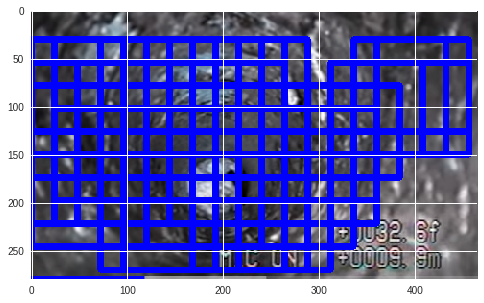

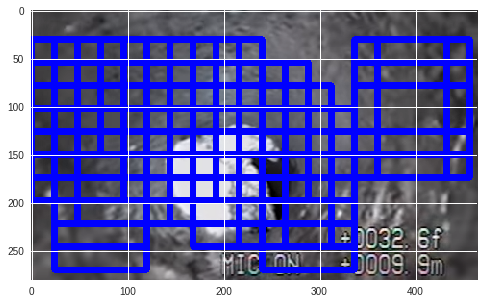

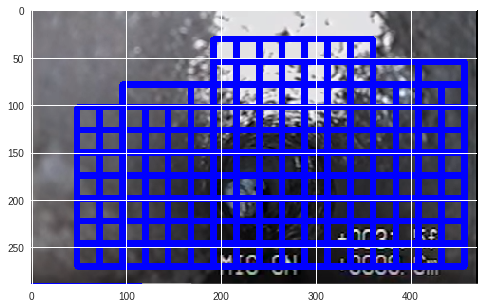

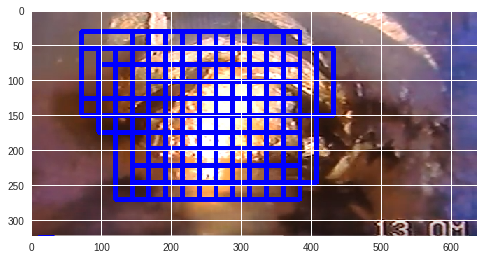

In [178]:
import matplotlib.pyplot as plt
ystart = 30
ystop = 270
scale = 1.5
pix_per_cell=8
cell_per_block=2
test_images=glob.glob('test/*.PNG')
# print(test_images)
for fname in test_images:
#     print(fname)
    test_img=cv2.imread(fname)
    plt.imshow(test_img)
    #plt.subplot(6,1,i)
    boxes=find_roots(test_img, ystart, ystop, scale, pix_per_cell,cell_per_block ) #, clf, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins)
    test_out_img=draw_boxes(test_img,boxes)
    plt.imshow(test_out_img)
    plt.show()

In [177]:
# os.chdir("content")
# !git pull origin melbournewater

# git pull origin experiment
!git clone https://github.com/shreyasrivastava17/test.git
!ls

Cloning into 'test'...
remote: Counting objects: 12, done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.
data		  heatmap added.ipynb  kerasmodel.json	test
Debris Detection  kerasmodel.h5        README.md


(289, 471, 3)


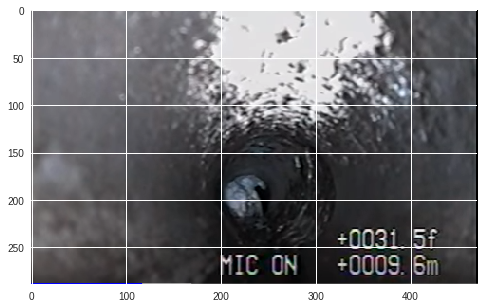

In [179]:
import matplotlib.pyplot as plt
img = cv2.imread("test/test1.PNG")
print(img.shape)
plt.imshow(img)
# cv2.imshow('image',img)

In [180]:
os.chdir("test")
!ls

heatmap added.ipynb  README.md	test1.PNG  test2.PNG  test3.PNG  test4.PNG


In [181]:
im = cv2.imread( "test1.PNG")
im = cv2.resize(im,(58,58))
print( round(inf_model.predict(np.expand_dims(im, 0))[0, 0]))

0.0


In [182]:
!ls
!git pull

heatmap added.ipynb  README.md	test1.PNG  test2.PNG  test3.PNG  test4.PNG
Already up-to-date.


In [0]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

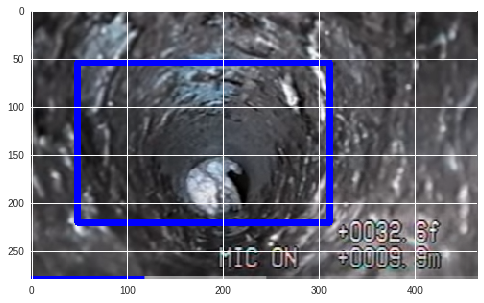

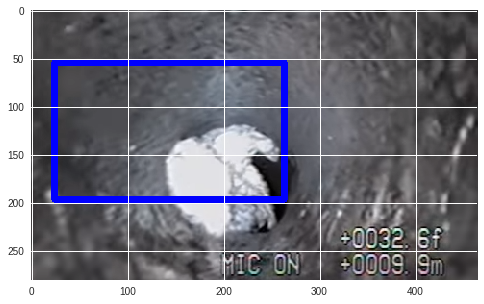

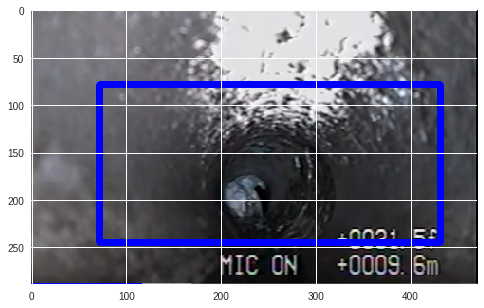

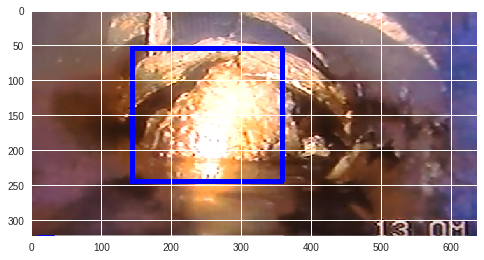

In [198]:
#print(scales,ystarts)
from collections import deque

heat_history=deque(maxlen=8)
def process_frame(image):
    boxes=[]
#     for i in range(len(scales)):
    boxes.append(find_roots(image, ystart, ystop, scale, pix_per_cell,cell_per_block )) #find_roots(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,color_space,spatial_size, hist_bins))
    
    boxes = [item for sublist in boxes for item in sublist] 
    heatmap_img = np.zeros_like(image[:,:,0])
    heatmap_img = add_heat(heatmap_img, boxes)
    
#     heat_history.append(heatmap_img)
#     heatmap_img = np.array(heat_history).sum(axis=0)
    heatmap_img = apply_threshold(heatmap_img,7)#
    
    # # Find final boxes from heatmap using label function
    labels = label(heatmap_img)#
    draw_img = draw_labeled_bboxes(np.copy(image), labels)#
#     draw_img = draw_boxes(image,boxes)
#     print(boxes)
    return draw_img
test_images=glob.glob('test/*.PNG')
for fname in test_images:
#     print(fname)
    test_img=cv2.imread(fname)
    plt.imshow(test_img)
    #plt.subplot(6,1,i)
    final_image=process_frame(test_img)
    plt.imshow(final_image)
    plt.show()
# plt.imshow(process_frame(im))


In [0]:
# os.chdir("Tree_Root_Detection")
# !wget 

In [0]:

# !git fetch --all
# !git reset --hard origin/master
# !git pull
# # # !ls
os.chdir("..")
# !ls

In [186]:
!pip install moviepy

In [201]:
from moviepy.editor import VideoFileClip

output_location = 'sewer_footage1_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
video_input = VideoFileClip("data/test_images/sewer_debris.mp4").subclip(70,72)

video_output = video_input.fl_image(process_frame) #NOTE: this function expects color images!!

#%time undist_clip.write_videofile(undist_output, audio=False)
# print("anupam")
video_output.write_videofile(output_location, audio=False)
video_input.reader.close()
video_input.audio.reader.close_proc()
video_output.reader.close()
video_output.audio.reader.close_proc()

[MoviePy] >>>> Building video sewer_footage1_output.mp4
[MoviePy] Writing video sewer_footage1_output.mp4


100%|██████████| 60/60 [00:07<00:00,  7.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: sewer_footage1_output.mp4 



In [202]:
!ls

data		     kerasmodel.h5    sewer_footage1_output.mp4
Debris Detection     kerasmodel.json  test
heatmap added.ipynb  README.md


In [0]:
from google.colab import files


files.download('sewer_footage1_output.mp4')


In [0]:
# os.chdir('..')

In [0]:

from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))



In [0]:
!git commit -m "output video"

In [0]:
!git config --global user.email "anupamb266@gmail.com"
! git config --global user.name "anupamhap"

In [0]:
!git push

In [0]:
!ls

Crack_Detection		   sewer_footage1	      test_image1.png
first working model.ipynb  sewer_footage1_output.mp4  Tree_Root_Detection


In [0]:
from google.colab import files


files.download('sewer_footage1_output.mp4')

In [0]:
!git pull

fatal: cannot run editor: No such file or directory
error: unable to start editor 'editor'
Not committing merge; use 'git commit' to complete the merge.


In [0]:
!git reset

Saved working directory and index state WIP on master: 905807b output video
